In [9]:
import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import time
from functools import reduce
import seaborn as sns
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch



In [3]:
current_dir = os.getcwd()  # Текущая рабочая директория

file_path_read_train = os.path.join(current_dir, "agentic_ai_performance_dataset_20250622.csv")

df = pd.read_csv(file_path_read_train)

Estimated source data:

agent_type

model_architecture

deployment_environment

task_category

task_complexity

autonomy_level

human_intervention_required

multimodal_capability

edge_compatibility

data_quality_score

timestamp

-------------------------------------
Estimated result data:

success_rate

accuracy_score

efficiency_score

execution_time_seconds

response_latency_ms

memory_usage_mb

cpu_usage_percent

cost_per_task_cents

error_recovery_rate

privacy_compliance_score

bias_detection_score

performance_index

cost_efficiency_ratio

autonomous_capability_score



----------------------------------------
Earliest Date

In [3]:
df['timestamp'].min()

'2024-12-24 04:16:15'

In [4]:
df['timestamp'].max()

'2025-06-22 04:16:16'

In [ ]:
# Days between earliest and latest dates
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['timestamp'].max() - df['timestamp'].min()

Timedelta('180 days 00:00:01')

We will use Correlation to identify whether ""data_quality_score"is an input type of data or the result.

In [ ]:
# Берём числовые колонки
numeric_df = df.select_dtypes(include=['float64', 'int64'])

# Считаем корреляцию
corrs = numeric_df.corr()['data_quality_score'].sort_values(ascending=False)

print(corrs)

Answer: "data_quality_score" is an input

--------------------------------------
Do we really need all output columns? Perhaps some are duplicating?

In [11]:
# 1. Выбрать только результативные колонки
result_columns = [
    'success_rate',
    'accuracy_score',
    'efficiency_score',
    'error_recovery_rate',
    'performance_index',
    'cost_efficiency_ratio',
    'autonomous_capability_score',
    'privacy_compliance_score',
    'bias_detection_score'
]

# Считаем матрицу корреляций
corr = numeric_df.corr()

# Оставляем только верхний треугольник (без диагонали), чтобы не было дублей
mask = np.triu(np.ones_like(corr, dtype=bool), k=1)
corr_upper = corr.where(mask)

# Собираем пары с корреляцией (0.9, 1)
pairs = (
    corr_upper.stack()
    .reset_index()
    .rename(columns={'level_0': 'col1', 'level_1': 'col2', 0: 'corr'})
    .query('corr > 0.96 and corr < 1')
    .sort_values('corr', ascending=False)
)

print(pairs)

                      col1                 col2      corr
73  execution_time_seconds  cost_per_task_cents  0.994297
42            success_rate    performance_index  0.980461
55          accuracy_score    performance_index  0.966085
38            success_rate  error_recovery_rate  0.965493
6          task_complexity      memory_usage_mb  0.962355
67        efficiency_score    performance_index  0.960090


Answer: while there are some high-correlated pairs, by logic it's best to leave all columns.

-----------------------------------
There are many output columns. While we do need all of them, to which one we should give priority when analyzing success of models?

In [ ]:
output_columns = [
    'success_rate','accuracy_score','efficiency_score',
    'error_recovery_rate','performance_index',
    'cost_efficiency_ratio','autonomous_capability_score',
    'privacy_compliance_score','bias_detection_score'
]

input_columns = [c for c in df.columns if c not in output_columns + ['agent_id','timestamp']]

cat_cols = [c for c in input_columns if df[c].dtype == 'object']
num_cols = [c for c in input_columns if df[c].dtype != 'object']

preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols),
    ('num', 'passthrough', num_cols)
])

# 1) берём подвыборку, чтобы не ждать вечно (потом уберёшь)
df_small = df.sample(min(1000, len(df)), random_state=42)

X = df_small[input_columns]
results = []

for y_col in output_columns:
    y = df_small[y_col]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    model = Pipeline([
        ('prep', preprocessor),
        ('rf', RandomForestRegressor(
            n_estimators=80,      # меньше деревьев
            max_depth=12,         # ограничиваем глубину
            min_samples_leaf=5,   # сглаживаем
            n_jobs=-1,            # параллелизм
            random_state=42
        ))
    ])

    t0 = time.time()
    model.fit(X_train, y_train)
    r2 = model.score(X_test, y_test)
    elapsed = time.time() - t0

    results.append((y_col, r2, round(elapsed, 2)))

results_df = pd.DataFrame(results, columns=['output_column','R2','fit_seconds'])\
             .sort_values('R2', ascending=False)
print(results_df)


                 output_column        R2  fit_seconds
5        cost_efficiency_ratio  0.982490         0.14
4            performance_index  0.961860         0.14
6  autonomous_capability_score  0.934598         0.15
0                 success_rate  0.930625         0.16
2             efficiency_score  0.909237         0.15
1               accuracy_score  0.893016         0.16
3          error_recovery_rate  0.887955         0.15
7     privacy_compliance_score -0.022135         0.14
8         bias_detection_score -0.051196         0.16


A list of all agents by Agent Type and Deployment Environment

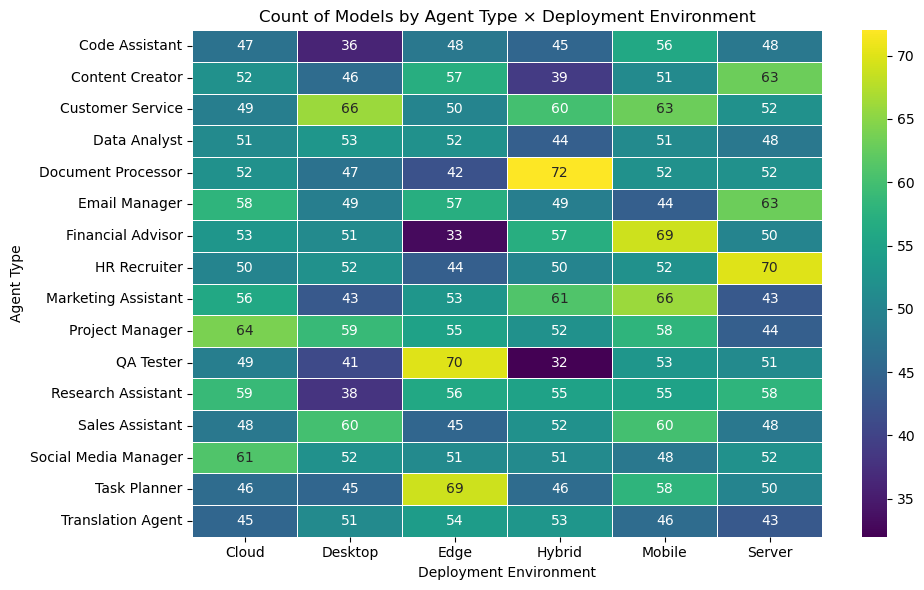

In [13]:
# Счёт количества моделей на стыке agent_type × deployment_environment
counts_df = (
    df.groupby(['agent_type', 'deployment_environment'])
      .size().reset_index(name='n_models')
)

# Матрица для heatmap (значения = количество моделей)
heat_df = counts_df.pivot(
    index='agent_type',
    columns='deployment_environment',
    values='n_models'
).fillna(0).astype(int)

# Рисуем heatmap: цвет и подписи зависят от количества
plt.figure(figsize=(10, 6))
sns.heatmap(
    heat_df,
    annot=True, fmt="d",
    cmap="viridis",
    linewidths=0.5, linecolor="white"
)
plt.title("Count of Models by Agent Type × Deployment Environment")
plt.xlabel("Deployment Environment")
plt.ylabel("Agent Type")
plt.tight_layout()
plt.show()


performance_index, success_rate, efficiency_score and accuracy_score: they all seem similar, yet might have different priority when deciding which models are more successful.

Columns by priority:

output_column        R2             fit_seconds

performance_index  0.961860         0.14  15
 
success_rate       0.930625         0.16   20

efficiency_score   0.909237         0.15   12

accuracy_score     0.893016         0.16    4



--------------------------------
Let's analyze "Performance Index"

We will create two separate databases for only successful models: performance index >= 0.75 and only failed models: performance index < 0.5.

In [36]:
df_failed_performance_index = df[df['performance_index'] <= 0.5]
df_successful_performance_index = df[df['performance_index'] >= 0.75]

In [37]:
print(len(df_failed_performance_index))

2083


In [38]:
print(len(df_successful_performance_index))

376


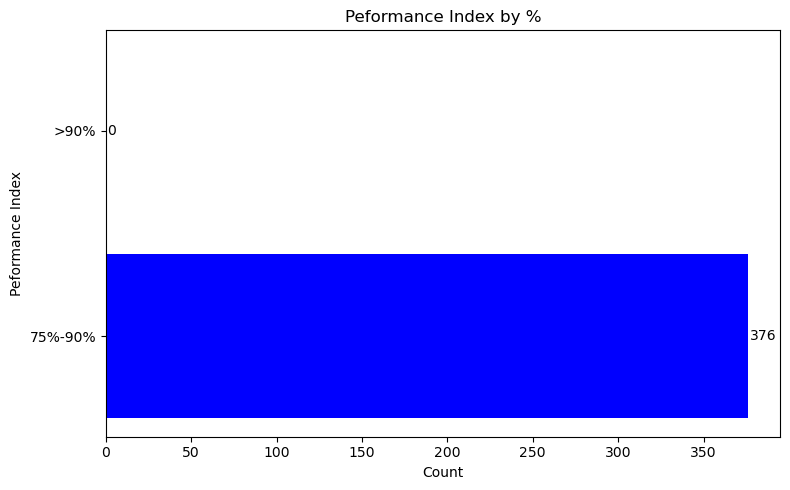

In [42]:
bins = [0.75, 0.9, 1.0]
labels = ['75%-90%', '>90%']
quartile_bins = pd.cut(df_successful_performance_index['performance_index'], bins=bins, labels=labels, include_lowest=True, right=True)
counts = quartile_bins.value_counts().sort_index()

fig, ax = plt.subplots(figsize=(8, 5))
bars = ax.barh(counts.index, counts.values, color='blue')

for bar in bars:
    width = bar.get_width()
    ax.text(width + 1, bar.get_y() + bar.get_height()/2,
            str(int(width)), va='center')

plt.title('Peformance Index by %')
plt.xlabel('Count')
plt.ylabel('Peformance Index')
plt.tight_layout()
plt.show()

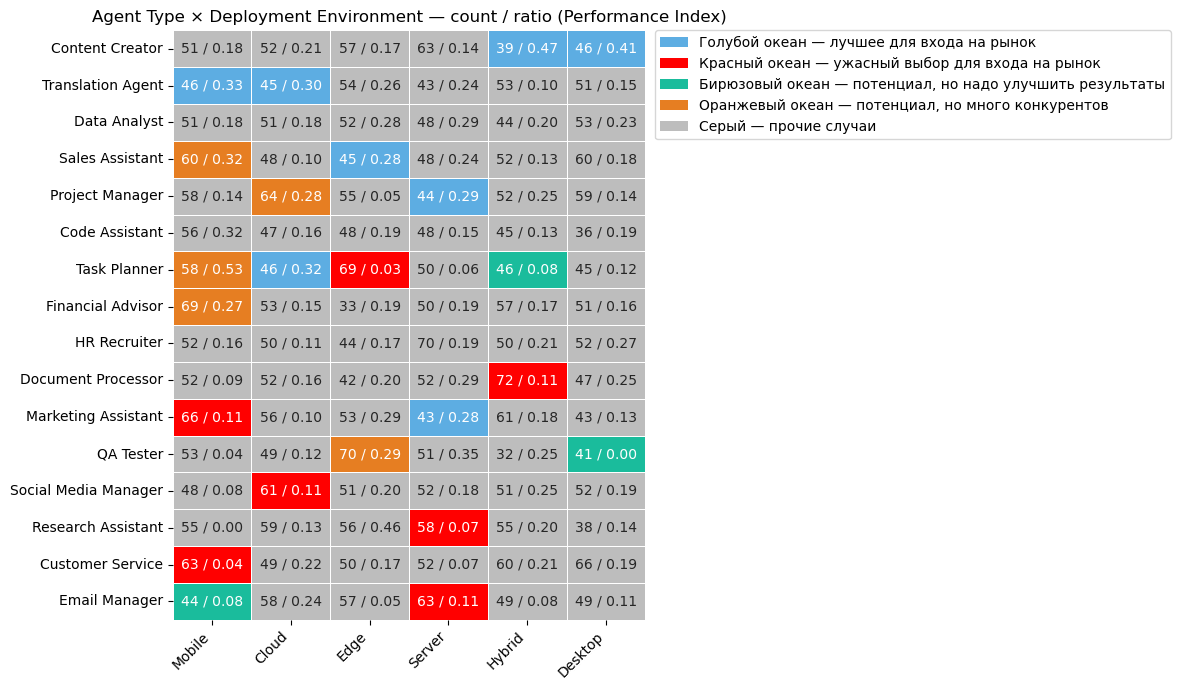

In [17]:
ratios_performance_index = []
for (atype, denv), group in df.groupby(['agent_type', 'deployment_environment']):
    success_count = (group['performance_index'] >= 0.75).sum()
    fail_count = (group['performance_index'] < 0.5).sum()

    if fail_count > 0:
        ratio = success_count / fail_count
    else:
        ratio = np.nan  # можно float('inf'), но NaN красивее в heatmap

    ratios_performance_index.append((atype, denv, ratio))

# Делаем DataFrame
ratios_performance_index_df = pd.DataFrame(
    ratios_performance_index,
    columns=['agent_type', 'deployment_environment', 'success_fail_ratio']
)

# Матрица ratio
heat_ratio = ratios_performance_index_df.pivot(
    index='agent_type', columns='deployment_environment', values='success_fail_ratio'
)

# Матрица count
counts_df = (
    df.groupby(['agent_type', 'deployment_environment']).size()
      .reset_index(name='n_models')
)
heat_count = counts_df.pivot(
    index='agent_type', columns='deployment_environment', values='n_models'
)

# Выравниваем индексы/колонки
common_index = sorted(set(heat_ratio.index) | set(heat_count.index))
common_cols = sorted(set(heat_ratio.columns) | set(heat_count.columns))
heat_ratio = heat_ratio.reindex(index=common_index, columns=common_cols)
heat_count = heat_count.reindex(index=common_index, columns=common_cols)

# --- 2) Сортировка осей для лучшей читаемости ---
row_order = heat_ratio.mean(axis=1, skipna=True).sort_values(ascending=False).index
col_order = heat_count.sum(axis=0, skipna=True).sort_values(ascending=False).index
heat_ratio = heat_ratio.loc[row_order, col_order]
heat_count = heat_count.loc[row_order, col_order]

# --- 3) Пороги по квартилям РАСПРЕДЕЛЕНИЙ (процентили), а не долям от максимума ---
q1_count, q3_count = np.nanpercentile(heat_count.values, [25, 75])
q1_ratio, q3_ratio = np.nanpercentile(heat_ratio.values, [25, 75])

# --- 4) Категоризация по цветам согласно правилам ---
# 0 = Серый (остальное), 1 = Зелёный, 2 = Красный, 3 = Жёлтый, 4 = Голубой
cat = np.zeros_like(heat_ratio.values, dtype=int)

count_vals = heat_count.values
ratio_vals = heat_ratio.values

# Маски условий
mask_green  = (count_vals <  q1_count) & (ratio_vals >  q3_ratio)    # лучшее для входа
mask_red    = (count_vals >  q3_count) & (ratio_vals <  q1_ratio)    # ужасный выбор
mask_yellow = (count_vals <  q1_count) & (ratio_vals <  q1_ratio)    # потенциал, но результаты низкие
mask_blue   = (count_vals >  q3_count) & (ratio_vals >  q3_ratio)    # потенциал, но конкуренция высокая

# Применяем
cat[mask_green]  = 1
cat[mask_red]    = 2
cat[mask_yellow] = 3
cat[mask_blue]   = 4

# Ячейки без данных (нет пары) — маска, чтобы не рисовать
mask_empty = heat_count.isna().values & heat_ratio.isna().values

# --- 5) Подписи вида "count / ratio" с аккуратным форматированием ---
def fmt_count(x):
    if pd.isna(x): return "-"
    x = float(x)
    return f"{x/1000:.2f}k" if x >= 1000 else str(int(x))

labels = np.empty_like(heat_ratio.values, dtype=object)
for i in range(labels.shape[0]):
    for j in range(labels.shape[1]):
        c = heat_count.iat[i, j]
        r = heat_ratio.iat[i, j]
        c_str = fmt_count(c)
        r_str = "-" if pd.isna(r) else f"{r:.2f}"
        labels[i, j] = "" if mask_empty[i, j] else f"{c_str} / {r_str}"

# --- 6) Палитра и легенда ---
cmap = ListedColormap([
    "#BDBDBD",  # 0 серый
    "#5DADE2",  # 1 голубой океан (лучшее для входа)
    "#FF0000",  # 2 красный океан (ужасный выбор)
    "#1ABC9C",  # 3 бирюзовый океан (потенциал, но надо улучшить результаты)
    "#E67E22"   # 4 оранжевый океан (потенциал, но много конкурентов)
])

legend_patches = [
    Patch(facecolor="#5DADE2", edgecolor='none', label="Голубой океан — лучшее для входа на рынок"),
    Patch(facecolor="#FF0000", edgecolor='none', label="Красный океан — ужасный выбор для входа на рынок"),
    Patch(facecolor="#1ABC9C", edgecolor='none', label="Бирюзовый океан — потенциал, но надо улучшить результаты"),
    Patch(facecolor="#E67E22", edgecolor='none', label="Оранжевый океан — потенциал, но много конкурентов"),
    Patch(facecolor="#BDBDBD", edgecolor='none', label="Серый — прочие случаи"),
]

# --- 7) Рисуем (данные для цвета — категории; подписи показывают count/ratio) ---
plt.figure(figsize=(12, 7))
ax = sns.heatmap(
    cat,
    cmap=cmap,
    cbar=False,
    annot=labels,
    fmt="",
    linewidths=0.5, linecolor="white",
    mask=mask_empty
)

ax.set_title("Agent Type × Deployment Environment — count / ratio (Performance Index)")

# Подписи осей
ax.set_yticks(np.arange(len(heat_ratio.index)) + 0.5)
ax.set_yticklabels(heat_ratio.index, rotation=0)
ax.set_xticks(np.arange(len(heat_ratio.columns)) + 0.5)
ax.set_xticklabels(heat_ratio.columns, rotation=45, ha='right')

# Легенда
ax.legend(handles=legend_patches, bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0.)

plt.tight_layout()
plt.show()


--------------------------------
Let's analyze "Success Rate"

We will create two separate databases for only successful models: success rate >= 0.75 and only failed models: success rate < 0.5.

In [45]:
df_failed_success_rate = df[df['success_rate'] <= 0.5]
df_successful_success_rate = df[df['success_rate'] >= 0.75]

In [47]:
print(len(df_failed_success_rate))

2790


In [48]:
print(len(df_successful_success_rate))

332


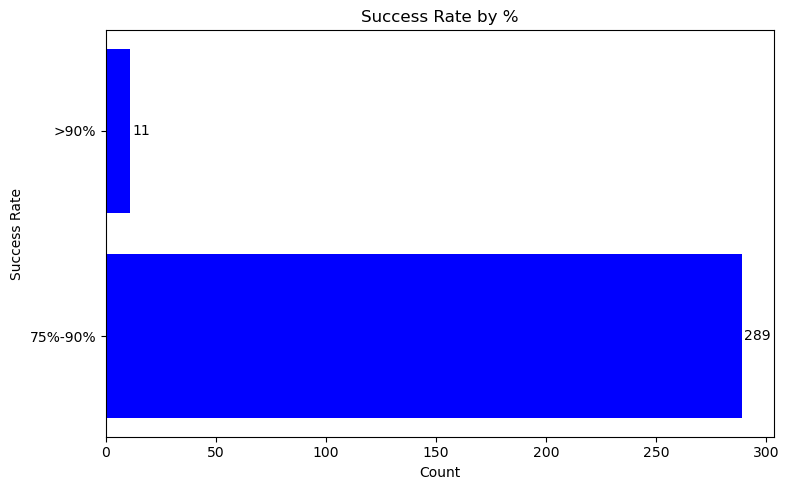

In [53]:
bins = [0.75, 0.9, 1.0]
labels = ['75%-90%', '>90%']
quartile_bins = pd.cut(df_successful_performance_index['success_rate'], bins=bins, labels=labels, include_lowest=True, right=True)
counts = quartile_bins.value_counts().sort_index()

fig, ax = plt.subplots(figsize=(8, 5))
bars = ax.barh(counts.index, counts.values, color='blue')

for bar in bars:
    width = bar.get_width()
    ax.text(width + 1, bar.get_y() + bar.get_height()/2,
            str(int(width)), va='center')

plt.title('Success Rate by %')
plt.xlabel('Count')
plt.ylabel('Success Rate')
plt.tight_layout()
plt.show()

AAA

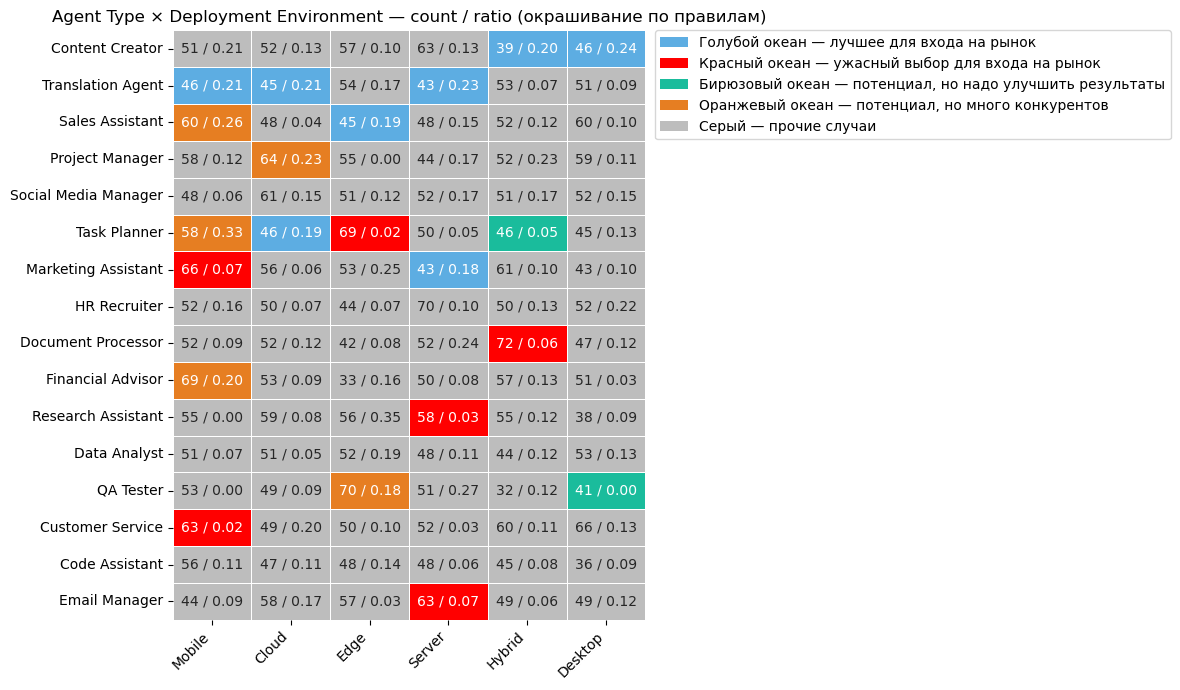

In [ ]:
ratios_success_rate = []
for (atype, denv), group in df.groupby(['agent_type', 'deployment_environment']):
    success_count = (group['success_rate'] >= 0.75).sum()
    fail_count = (group['success_rate'] < 0.5).sum()

    if fail_count > 0:
        ratio = success_count / fail_count
    else:
        ratio = np.nan  # можно float('inf'), но NaN красивее в heatmap

    ratios_success_rate.append((atype, denv, ratio))

# Делаем DataFrame
ratios_success_rate_df = pd.DataFrame(
    ratios_success_rate,
    columns=['agent_type', 'deployment_environment', 'success_fail_ratio']
)

# Матрица ratio
heat_ratio = ratios_success_rate_df.pivot(
    index='agent_type', columns='deployment_environment', values='success_fail_ratio'
)

# Матрица count
counts_df = (
    df.groupby(['agent_type', 'deployment_environment']).size()
      .reset_index(name='n_models')
)
heat_count = counts_df.pivot(
    index='agent_type', columns='deployment_environment', values='n_models'
)

# Выравниваем индексы/колонки
common_index = sorted(set(heat_ratio.index) | set(heat_count.index))
common_cols = sorted(set(heat_ratio.columns) | set(heat_count.columns))
heat_ratio = heat_ratio.reindex(index=common_index, columns=common_cols)
heat_count = heat_count.reindex(index=common_index, columns=common_cols)

# --- 2) Сортировка осей для лучшей читаемости ---
row_order = heat_ratio.mean(axis=1, skipna=True).sort_values(ascending=False).index
col_order = heat_count.sum(axis=0, skipna=True).sort_values(ascending=False).index
heat_ratio = heat_ratio.loc[row_order, col_order]
heat_count = heat_count.loc[row_order, col_order]

# --- 3) Пороги по квартилям РАСПРЕДЕЛЕНИЙ (процентили), а не долям от максимума ---
q1_count, q3_count = np.nanpercentile(heat_count.values, [25, 75])
q1_ratio, q3_ratio = np.nanpercentile(heat_ratio.values, [25, 75])

# --- 4) Категоризация по цветам согласно правилам ---
# 0 = Серый (остальное), 1 = Зелёный, 2 = Красный, 3 = Жёлтый, 4 = Голубой
cat = np.zeros_like(heat_ratio.values, dtype=int)

count_vals = heat_count.values
ratio_vals = heat_ratio.values

# Маски условий
mask_green  = (count_vals <  q1_count) & (ratio_vals >  q3_ratio)    # лучшее для входа
mask_red    = (count_vals >  q3_count) & (ratio_vals <  q1_ratio)    # ужасный выбор
mask_yellow = (count_vals <  q1_count) & (ratio_vals <  q1_ratio)    # потенциал, но результаты низкие
mask_blue   = (count_vals >  q3_count) & (ratio_vals >  q3_ratio)    # потенциал, но конкуренция высокая

# Применяем
cat[mask_green]  = 1
cat[mask_red]    = 2
cat[mask_yellow] = 3
cat[mask_blue]   = 4

# Ячейки без данных (нет пары) — маска, чтобы не рисовать
mask_empty = heat_count.isna().values & heat_ratio.isna().values

# --- 5) Подписи вида "count / ratio" с аккуратным форматированием ---
def fmt_count(x):
    if pd.isna(x): return "-"
    x = float(x)
    return f"{x/1000:.2f}k" if x >= 1000 else str(int(x))

labels = np.empty_like(heat_ratio.values, dtype=object)
for i in range(labels.shape[0]):
    for j in range(labels.shape[1]):
        c = heat_count.iat[i, j]
        r = heat_ratio.iat[i, j]
        c_str = fmt_count(c)
        r_str = "-" if pd.isna(r) else f"{r:.2f}"
        labels[i, j] = "" if mask_empty[i, j] else f"{c_str} / {r_str}"

# --- 6) Палитра и легенда ---
cmap = ListedColormap([
    "#BDBDBD",  # 0 серый
    "#5DADE2",  # 1 голубой океан (лучшее для входа)
    "#FF0000",  # 2 красный океан (ужасный выбор)
    "#1ABC9C",  # 3 бирюзовый океан (потенциал, но надо улучшить результаты)
    "#E67E22"   # 4 оранжевый океан (потенциал, но много конкурентов)
])

legend_patches = [
    Patch(facecolor="#5DADE2", edgecolor='none', label="Голубой океан — лучшее для входа на рынок"),
    Patch(facecolor="#FF0000", edgecolor='none', label="Красный океан — ужасный выбор для входа на рынок"),
    Patch(facecolor="#1ABC9C", edgecolor='none', label="Бирюзовый океан — потенциал, но надо улучшить результаты"),
    Patch(facecolor="#E67E22", edgecolor='none', label="Оранжевый океан — потенциал, но много конкурентов"),
    Patch(facecolor="#BDBDBD", edgecolor='none', label="Серый — прочие случаи"),
]

# --- 7) Рисуем (данные для цвета — категории; подписи показывают count/ratio) ---
plt.figure(figsize=(12, 7))
ax = sns.heatmap(
    cat,
    cmap=cmap,
    cbar=False,
    annot=labels,
    fmt="",
    linewidths=0.5, linecolor="white",
    mask=mask_empty
)

ax.set_title("Agent Type × Deployment Environment — count / ratio (Success Rate)")

# Подписи осей
ax.set_yticks(np.arange(len(heat_ratio.index)) + 0.5)
ax.set_yticklabels(heat_ratio.index, rotation=0)
ax.set_xticks(np.arange(len(heat_ratio.columns)) + 0.5)
ax.set_xticklabels(heat_ratio.columns, rotation=45, ha='right')

# Легенда
ax.legend(handles=legend_patches, bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0.)

plt.tight_layout()
plt.show()


----------------------------------------------
Let's analyze "Efficiency Score"

We will create two separate databases for only successful models: efficiency score >= 0.75 and only failed models: efficiency score < 0.5.

In [6]:
df_failed_efficiency_score = df[df['efficiency_score'] <= 0.5]
df_successful_efficiency_score = df[df['efficiency_score'] >= 0.75]

In [10]:
print(len(df_failed_efficiency_score))

1228


In [11]:
print(len(df_successful_efficiency_score))

453


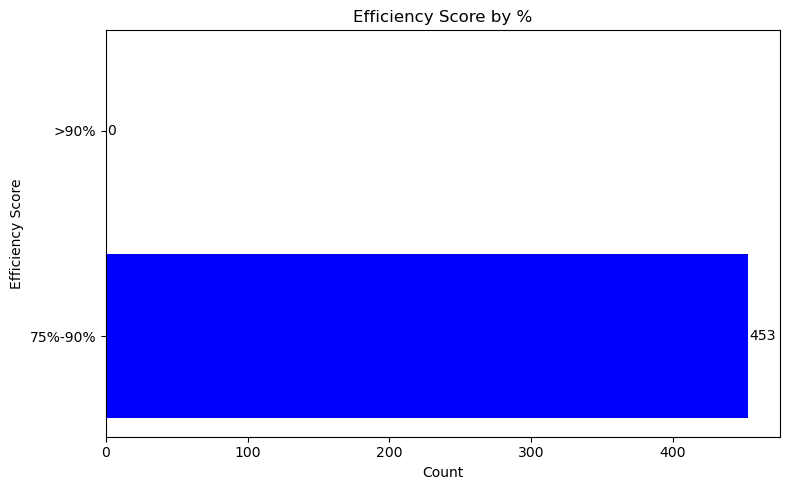

In [9]:
bins = [0.75, 0.9, 1.0]
labels = ['75%-90%', '>90%']
quartile_bins = pd.cut(df_successful_efficiency_score['efficiency_score'], bins=bins, labels=labels, include_lowest=True, right=True)
counts = quartile_bins.value_counts().sort_index()

fig, ax = plt.subplots(figsize=(8, 5))
bars = ax.barh(counts.index, counts.values, color='blue')

for bar in bars:
    width = bar.get_width()
    ax.text(width + 1, bar.get_y() + bar.get_height()/2,
            str(int(width)), va='center')

plt.title('Efficiency Score by %')
plt.xlabel('Count')
plt.ylabel('Efficiency Score')
plt.tight_layout()
plt.show()

AAA

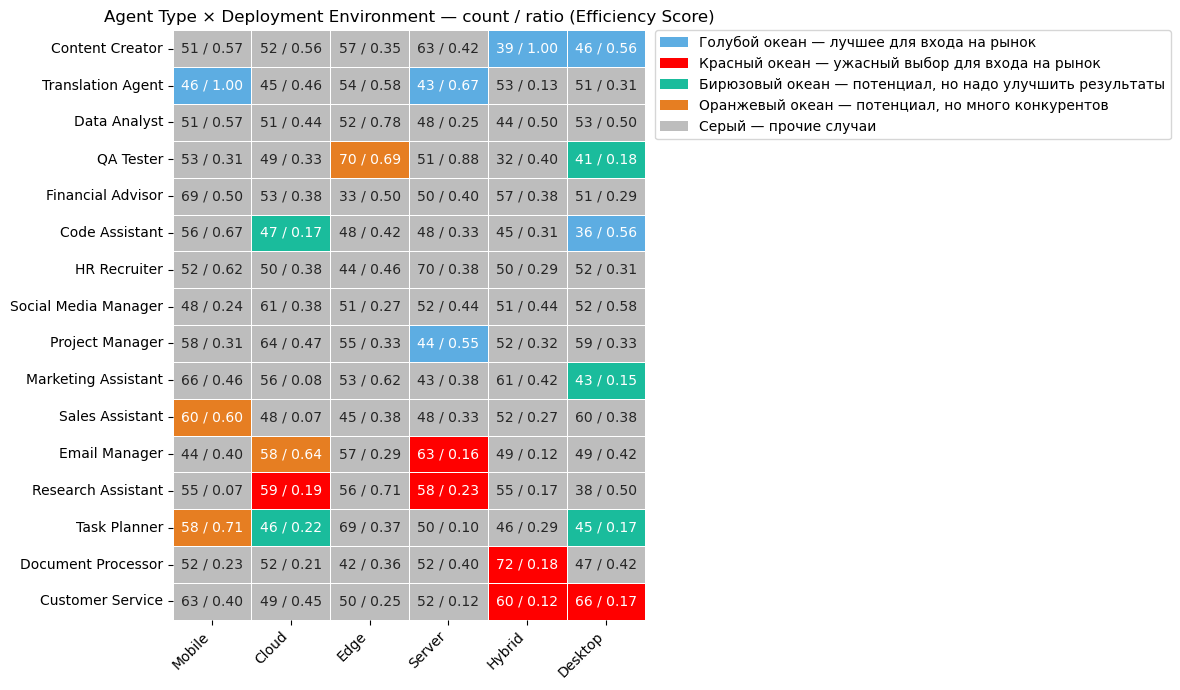

In [18]:
ratios_efficiency_score = []
for (atype, denv), group in df.groupby(['agent_type', 'deployment_environment']):
    success_count = (group['efficiency_score'] >= 0.75).sum()
    fail_count = (group['efficiency_score'] < 0.5).sum()

    if fail_count > 0:
        ratio = success_count / fail_count
    else:
        ratio = np.nan  # можно float('inf'), но NaN красивее в heatmap

    ratios_efficiency_score.append((atype, denv, ratio))

# Делаем DataFrame
ratios_efficiency_score_df = pd.DataFrame(
    ratios_efficiency_score,
    columns=['agent_type', 'deployment_environment', 'success_fail_ratio']
)

# Матрица ratio
heat_ratio = ratios_efficiency_score_df.pivot(
    index='agent_type', columns='deployment_environment', values='success_fail_ratio'
)

# Матрица count
counts_df = (
    df.groupby(['agent_type', 'deployment_environment']).size()
      .reset_index(name='n_models')
)
heat_count = counts_df.pivot(
    index='agent_type', columns='deployment_environment', values='n_models'
)

# Выравниваем индексы/колонки
common_index = sorted(set(heat_ratio.index) | set(heat_count.index))
common_cols = sorted(set(heat_ratio.columns) | set(heat_count.columns))
heat_ratio = heat_ratio.reindex(index=common_index, columns=common_cols)
heat_count = heat_count.reindex(index=common_index, columns=common_cols)

# --- 2) Сортировка осей для лучшей читаемости ---
row_order = heat_ratio.mean(axis=1, skipna=True).sort_values(ascending=False).index
col_order = heat_count.sum(axis=0, skipna=True).sort_values(ascending=False).index
heat_ratio = heat_ratio.loc[row_order, col_order]
heat_count = heat_count.loc[row_order, col_order]

# --- 3) Пороги по квартилям РАСПРЕДЕЛЕНИЙ (процентили), а не долям от максимума ---
q1_count, q3_count = np.nanpercentile(heat_count.values, [25, 75])
q1_ratio, q3_ratio = np.nanpercentile(heat_ratio.values, [25, 75])

# --- 4) Категоризация по цветам согласно правилам ---
# 0 = Серый (остальное), 1 = Зелёный, 2 = Красный, 3 = Жёлтый, 4 = Голубой
cat = np.zeros_like(heat_ratio.values, dtype=int)

count_vals = heat_count.values
ratio_vals = heat_ratio.values

# Маски условий
mask_green  = (count_vals <  q1_count) & (ratio_vals >  q3_ratio)    # лучшее для входа
mask_red    = (count_vals >  q3_count) & (ratio_vals <  q1_ratio)    # ужасный выбор
mask_yellow = (count_vals <  q1_count) & (ratio_vals <  q1_ratio)    # потенциал, но результаты низкие
mask_blue   = (count_vals >  q3_count) & (ratio_vals >  q3_ratio)    # потенциал, но конкуренция высокая

# Применяем
cat[mask_green]  = 1
cat[mask_red]    = 2
cat[mask_yellow] = 3
cat[mask_blue]   = 4

# Ячейки без данных (нет пары) — маска, чтобы не рисовать
mask_empty = heat_count.isna().values & heat_ratio.isna().values

# --- 5) Подписи вида "count / ratio" с аккуратным форматированием ---
def fmt_count(x):
    if pd.isna(x): return "-"
    x = float(x)
    return f"{x/1000:.2f}k" if x >= 1000 else str(int(x))

labels = np.empty_like(heat_ratio.values, dtype=object)
for i in range(labels.shape[0]):
    for j in range(labels.shape[1]):
        c = heat_count.iat[i, j]
        r = heat_ratio.iat[i, j]
        c_str = fmt_count(c)
        r_str = "-" if pd.isna(r) else f"{r:.2f}"
        labels[i, j] = "" if mask_empty[i, j] else f"{c_str} / {r_str}"

# --- 6) Палитра и легенда ---
cmap = ListedColormap([
    "#BDBDBD",  # 0 серый
    "#5DADE2",  # 1 голубой океан (лучшее для входа)
    "#FF0000",  # 2 красный океан (ужасный выбор)
    "#1ABC9C",  # 3 бирюзовый океан (потенциал, но надо улучшить результаты)
    "#E67E22"   # 4 оранжевый океан (потенциал, но много конкурентов)
])

legend_patches = [
    Patch(facecolor="#5DADE2", edgecolor='none', label="Голубой океан — лучшее для входа на рынок"),
    Patch(facecolor="#FF0000", edgecolor='none', label="Красный океан — ужасный выбор для входа на рынок"),
    Patch(facecolor="#1ABC9C", edgecolor='none', label="Бирюзовый океан — потенциал, но надо улучшить результаты"),
    Patch(facecolor="#E67E22", edgecolor='none', label="Оранжевый океан — потенциал, но много конкурентов"),
    Patch(facecolor="#BDBDBD", edgecolor='none', label="Серый — прочие случаи"),
]

# --- 7) Рисуем (данные для цвета — категории; подписи показывают count/ratio) ---
plt.figure(figsize=(12, 7))
ax = sns.heatmap(
    cat,
    cmap=cmap,
    cbar=False,
    annot=labels,
    fmt="",
    linewidths=0.5, linecolor="white",
    mask=mask_empty
)

ax.set_title("Agent Type × Deployment Environment — count / ratio (Efficiency Score)")

# Подписи осей
ax.set_yticks(np.arange(len(heat_ratio.index)) + 0.5)
ax.set_yticklabels(heat_ratio.index, rotation=0)
ax.set_xticks(np.arange(len(heat_ratio.columns)) + 0.5)
ax.set_xticklabels(heat_ratio.columns, rotation=45, ha='right')

# Легенда
ax.legend(handles=legend_patches, bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0.)

plt.tight_layout()
plt.show()


--------------------------------
Let's analyze "Performance Index"

We will create two separate databases for only successful models: performance index >= 0.75 and only failed models: performance index < 0.5.

In [20]:
df_failed_accuracy_score = df[df['accuracy_score'] <= 0.5]
df_successful_accuracy_score = df[df['accuracy_score'] >= 0.75]

In [21]:
print(len(df_failed_accuracy_score))

1698


In [22]:
print(len(df_successful_accuracy_score))

495


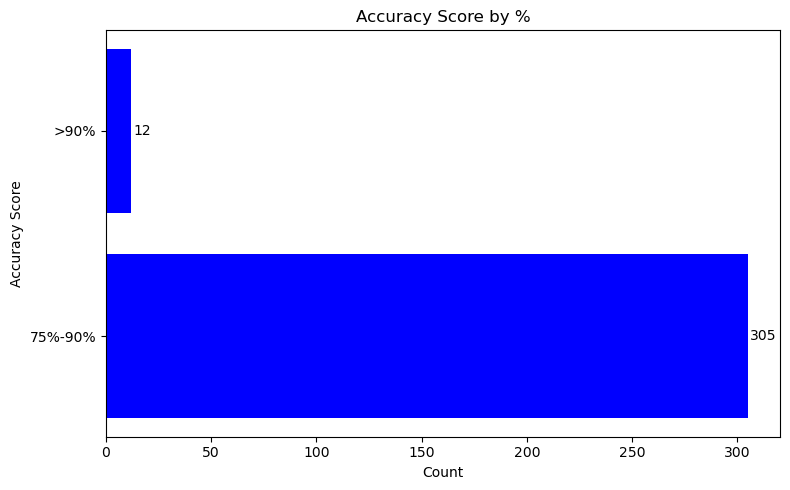

In [25]:
bins = [0.75, 0.9, 1.0]
labels = ['75%-90%', '>90%']
quartile_bins = pd.cut(df_successful_efficiency_score['accuracy_score'], bins=bins, labels=labels, include_lowest=True, right=True)
counts = quartile_bins.value_counts().sort_index()

fig, ax = plt.subplots(figsize=(8, 5))
bars = ax.barh(counts.index, counts.values, color='blue')

for bar in bars:
    width = bar.get_width()
    ax.text(width + 1, bar.get_y() + bar.get_height()/2,
            str(int(width)), va='center')

plt.title('Accuracy Score by %')
plt.xlabel('Count')
plt.ylabel('Accuracy Score')
plt.tight_layout()
plt.show()

AAA

In [ ]:
ratios_accuracy_score = []
for (atype, denv), group in df.groupby(['agent_type', 'deployment_environment']):
    success_count = (group['accuracy_score'] >= 0.75).sum()
    fail_count = (group['accuracy_score'] < 0.5).sum()

    if fail_count > 0:
        ratio = success_count / fail_count
    else:
        ratio = np.nan  # можно float('inf'), но NaN красивее в heatmap

    ratios_accuracy_score.append((atype, denv, ratio))

# Делаем DataFrame
ratios_accuracy_score_df = pd.DataFrame(
    ratios_accuracy_score,
    columns=['agent_type', 'deployment_environment', 'success_fail_ratio']
)

# Матрица ratio
heat_ratio = ratios_accuracy_score_df.pivot(
    index='agent_type', columns='deployment_environment', values='success_fail_ratio'
)

# Матрица count
counts_df = (
    df.groupby(['agent_type', 'deployment_environment']).size()
      .reset_index(name='n_models')
)
heat_count = counts_df.pivot(
    index='agent_type', columns='deployment_environment', values='n_models'
)

# Выравниваем индексы/колонки
common_index = sorted(set(heat_ratio.index) | set(heat_count.index))
common_cols = sorted(set(heat_ratio.columns) | set(heat_count.columns))
heat_ratio = heat_ratio.reindex(index=common_index, columns=common_cols)
heat_count = heat_count.reindex(index=common_index, columns=common_cols)

# --- 2) Сортировка осей для лучшей читаемости ---
row_order = heat_ratio.mean(axis=1, skipna=True).sort_values(ascending=False).index
col_order = heat_count.sum(axis=0, skipna=True).sort_values(ascending=False).index
heat_ratio = heat_ratio.loc[row_order, col_order]
heat_count = heat_count.loc[row_order, col_order]

# --- 3) Пороги по квартилям РАСПРЕДЕЛЕНИЙ (процентили), а не долям от максимума ---
q1_count, q3_count = np.nanpercentile(heat_count.values, [25, 75])
q1_ratio, q3_ratio = np.nanpercentile(heat_ratio.values, [25, 75])

# --- 4) Категоризация по цветам согласно правилам ---
# 0 = Серый (остальное), 1 = Зелёный, 2 = Красный, 3 = Жёлтый, 4 = Голубой
cat = np.zeros_like(heat_ratio.values, dtype=int)

count_vals = heat_count.values
ratio_vals = heat_ratio.values

# Маски условий
mask_green  = (count_vals <  q1_count) & (ratio_vals >  q3_ratio)    # лучшее для входа
mask_red    = (count_vals >  q3_count) & (ratio_vals <  q1_ratio)    # ужасный выбор
mask_yellow = (count_vals <  q1_count) & (ratio_vals <  q1_ratio)    # потенциал, но результаты низкие
mask_blue   = (count_vals >  q3_count) & (ratio_vals >  q3_ratio)    # потенциал, но конкуренция высокая

# Применяем
cat[mask_green]  = 1
cat[mask_red]    = 2
cat[mask_yellow] = 3
cat[mask_blue]   = 4

# Ячейки без данных (нет пары) — маска, чтобы не рисовать
mask_empty = heat_count.isna().values & heat_ratio.isna().values

# --- 5) Подписи вида "count / ratio" с аккуратным форматированием ---
def fmt_count(x):
    if pd.isna(x): return "-"
    x = float(x)
    return f"{x/1000:.2f}k" if x >= 1000 else str(int(x))

labels = np.empty_like(heat_ratio.values, dtype=object)
for i in range(labels.shape[0]):
    for j in range(labels.shape[1]):
        c = heat_count.iat[i, j]
        r = heat_ratio.iat[i, j]
        c_str = fmt_count(c)
        r_str = "-" if pd.isna(r) else f"{r:.2f}"
        labels[i, j] = "" if mask_empty[i, j] else f"{c_str} / {r_str}"

# --- 6) Палитра и легенда ---
cmap = ListedColormap([
    "#BDBDBD",  # 0 серый
    "#5DADE2",  # 1 голубой океан (лучшее для входа)
    "#FF0000",  # 2 красный океан (ужасный выбор)
    "#1ABC9C",  # 3 бирюзовый океан (потенциал, но надо улучшить результаты)
    "#E67E22"   # 4 оранжевый океан (потенциал, но много конкурентов)
])

legend_patches = [
    Patch(facecolor="#5DADE2", edgecolor='none', label="Голубой океан — лучшее для входа на рынок"),
    Patch(facecolor="#FF0000", edgecolor='none', label="Красный океан — ужасный выбор для входа на рынок"),
    Patch(facecolor="#1ABC9C", edgecolor='none', label="Бирюзовый океан — потенциал, но надо улучшить результаты"),
    Patch(facecolor="#E67E22", edgecolor='none', label="Оранжевый океан — потенциал, но много конкурентов"),
    Patch(facecolor="#BDBDBD", edgecolor='none', label="Серый — прочие случаи"),
]

# --- 7) Рисуем (данные для цвета — категории; подписи показывают count/ratio) ---
plt.figure(figsize=(12, 7))
ax = sns.heatmap(
    cat,
    cmap=cmap,
    cbar=False,
    annot=labels,
    fmt="",
    linewidths=0.5, linecolor="white",
    mask=mask_empty
)

ax.set_title("Agent Type × Deployment Environment — count / ratio (Accuracy Score)")

# Подписи осей
ax.set_yticks(np.arange(len(heat_ratio.index)) + 0.5)
ax.set_yticklabels(heat_ratio.index, rotation=0)
ax.set_xticks(np.arange(len(heat_ratio.columns)) + 0.5)
ax.set_xticklabels(heat_ratio.columns, rotation=45, ha='right')

# Легенда
ax.legend(handles=legend_patches, bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0.)

plt.tight_layout()
plt.show()
